## Lasso Regression on imdb movie reviews for rating prediction

In [1]:
import pickle
import os
ROOT_PATH = '../../'
data_path = os.path.join(ROOT_PATH,'data/processed/imdb/data.pickle')

with open(data_path,"rb") as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

In [2]:
print([el.shape for el in [X_train,X_test,y_train,y_test]])

[(25000, 44798), (25000, 44798), (25000,), (25000,)]


In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, ElasticNet, LinearRegression
from sklearn.metrics import mean_squared_error


def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    return mean_squared_error(y_test, preds, squared=False)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

alphas = np.concatenate([np.linspace(1e-5,1e-4,9),np.linspace(1e-4,1e-3,9)])
lasso = Pipeline([
    # ("scaler", StandardScaler()),
    ("model",Lasso(max_iter=10000))
])
print(f"Searching for alphas: {alphas}")
grid = GridSearchCV(lasso, param_grid={'model__alpha': alphas}, cv=5, scoring='neg_mean_squared_error',verbose=2)
grid.fit(X_train, y_train)
  
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best alpha:", grid.best_params_['model__alpha'])
print("Test MSE:", mse)

Searching for alphas: [1.000e-05 2.125e-05 3.250e-05 4.375e-05 5.500e-05 6.625e-05 7.750e-05
 8.875e-05 1.000e-04 1.000e-04 2.125e-04 3.250e-04 4.375e-04 5.500e-04
 6.625e-04 7.750e-04 8.875e-04 1.000e-03]
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END .................................model__alpha=1e-05; total time= 8.0min
[CV] END .................................model__alpha=1e-05; total time= 3.2min
[CV] END .................................model__alpha=1e-05; total time= 6.1min
[CV] END .................................model__alpha=1e-05; total time=20.9min
[CV] END .................................model__alpha=1e-05; total time= 4.2min
[CV] END .............................model__alpha=2.125e-05; total time= 2.5min
[CV] END .............................model__alpha=2.125e-05; total time= 2.0min
[CV] END .............................model__alpha=2.125e-05; total time= 1.7min
[CV] END .............................model__alpha=2.125e-05; total time= 1.8min
[CV]

In [10]:
import numpy as np
import pandas as pd

results = grid.cv_results_
# print(results.keys())
alphas = results["param_model__alpha"].data.astype(float)
rmse = -results["mean_test_score"]   # convert neg RMSE → RMSE

df = pd.DataFrame({
    "alpha": alphas,
    "rmse": rmse
}).sort_values("alpha")

print(df)

       alpha      rmse
0   0.000010  7.900785
1   0.000021  6.615635
2   0.000033  6.136620
3   0.000044  5.907321
4   0.000055  5.788990
5   0.000066  5.733463
6   0.000077  5.713257
7   0.000089  5.714832
9   0.000100  5.727499
8   0.000100  5.727499
10  0.000213  6.047552
11  0.000325  6.362923
12  0.000438  6.649010
13  0.000550  6.905905
14  0.000663  7.132417
15  0.000775  7.332925
16  0.000888  7.519726
17  0.001000  7.698353


| idx |   alpha   |     mse     |
|----:|-----------:|-----------:|
|  0  | 0.000010   | 7.900785   |
|  1  | 0.000021   | 6.615635   |
|  2  | 0.000033   | 6.136620   |
|  3  | 0.000044   | 5.907321   |
|  4  | 0.000055   | 5.788990   |
|  5  | 0.000066   | 5.733463   |
|  6  | 0.000077   | 5.713257   |
|  7  | 0.000089   | 5.714832   |
|  9  | 0.000100   | 5.727499   |
|  8  | 0.000100   | 5.727499   |
| 10  | 0.000213   | 6.047552   |
| 11  | 0.000325   | 6.362923   |
| 12  | 0.000438   | 6.649010   |
| 13  | 0.000550   | 6.905905   |
| 14  | 0.000663   | 7.132417   |
| 15  | 0.000775   | 7.332925   |
| 16  | 0.000888   | 7.519726   |
| 17  | 0.001000   | 7.698353   |


In [14]:
print("Best alpha:", grid.best_params_['model__alpha'])
print("Test MSE:", mse)

Best alpha: 0.001
Test MSE: 5.786458705366045


In [3]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# X, y, coef = make_regression(n_samples=100, n_features=1000, n_informative=10, noise=0.1, coef=True, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

counter = 1
prev_mse = float('inf')
while True:
    lasso = Lasso(alpha=10**(-counter), max_iter=10000).fit(X_train, y_train)
    print(f"Alpha = 1e-{counter}")
    current_mse =  mean_squared_error(y_test, lasso.predict(X_test))
    print("Lasso MSE:", current_mse)
    print("Number of nonzero coefficients (Lasso):", (lasso.coef_ != 0).sum())
    if current_mse > prev_mse:
        break
    counter += 1
    prev_mse = current_mse


ols = LinearRegression().fit(X_train, y_train)
print("OLS MSE:", mean_squared_error(y_test, ols.predict(X_test)))


Alpha = 1e-1
Lasso MSE: 12.187153896000002
Number of nonzero coefficients (Lasso): 0
Alpha = 1e-2
Lasso MSE: 9.880973769676409
Number of nonzero coefficients (Lasso): 16
Alpha = 1e-3
Lasso MSE: 5.852790231405661
Number of nonzero coefficients (Lasso): 291
Alpha = 1e-4
Lasso MSE: 4.86344587555825
Number of nonzero coefficients (Lasso): 3579
Alpha = 1e-5
Lasso MSE: 7.541218999261168
Number of nonzero coefficients (Lasso): 17060
OLS MSE: 15.743034082448268


In [ ]:
from sklearn.linear_model import Ridge
# X, y, coef = make_regression(n_samples=100, n_features=1000, n_informative=10, noise=0.1, coef=True, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

counter = 1
prev_mse = float('inf')
threshold = 1e-4
while True:
    model = Ridge(alpha=10**(-counter), max_iter=10000).fit(X_train, y_train)
    print(f"Alpha = 1e-{counter}")
    current_mse =  mean_squared_error(y_test, model.predict(X_test))
    print("Ridge MSE:", current_mse)
    print("Number of nonzero coefficients (Ridge) > 1e-4:", (model.coef_ > threshold).sum())
    if current_mse > prev_mse:
        break
    counter += 1
    prev_mse = current_mse


ols = LinearRegression().fit(X_train, y_train)
print("OLS MSE:", mean_squared_error(y_test, ols.predict(X_test)))


Alpha = 1e-1
Ridge MSE: 6.395552042010892
Number of nonzero coefficients (Lasso) > 1e-4: 22189
Alpha = 1e-2
Ridge MSE: 10.459718794357043
Number of nonzero coefficients (Lasso) > 1e-4: 22141
OLS MSE: 15.743034082448268


In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np

alphas = np.concatenate([np.linspace(1e-2,1e-1,9),np.linspace(1e-1,1,9)])
lasso = Pipeline([
    # ("scaler", StandardScaler()),
    ("model",Ridge(max_iter=10000))
])
print(f"Searching for alphas: {alphas}")
grid = GridSearchCV(lasso, param_grid={'model__alpha': alphas}, cv=5, scoring='neg_mean_squared_error',verbose=2)
grid.fit(X_train, y_train)
  
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Best alpha:", grid.best_params_['model__alpha'])
print("Test MSE:", mse)

Searching for alphas: [0.01    0.02125 0.0325  0.04375 0.055   0.06625 0.0775  0.08875 0.1
 0.1     0.2125  0.325   0.4375  0.55    0.6625  0.775   0.8875  1.     ]
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END ..................................model__alpha=0.01; total time=   3.3s
[CV] END ..................................model__alpha=0.01; total time=   2.6s
[CV] END ..................................model__alpha=0.01; total time=   2.8s
[CV] END ..................................model__alpha=0.01; total time=   3.0s
[CV] END ..................................model__alpha=0.01; total time=   2.5s
[CV] END ...............................model__alpha=0.02125; total time=   2.2s
[CV] END ...............................model__alpha=0.02125; total time=   1.9s
[CV] END ...............................model__alpha=0.02125; total time=   3.0s
[CV] END ...............................model__alpha=0.02125; total time=   2.8s
[CV] END ...............................model

In [15]:
import numpy as np
import pandas as pd

results = grid.cv_results_
# print(results.keys())
alphas = results["param_model__alpha"].data.astype(float)
rmse = -results["mean_test_score"]   # convert neg RMSE → RMSE

df = pd.DataFrame({
    "alpha": alphas,
    "rmse": rmse
}).sort_values("alpha")

print(df)

      alpha      rmse
0   0.01000  9.164694
1   0.02125  8.169875
2   0.03250  7.608546
3   0.04375  7.237661
4   0.05500  6.969221
5   0.06625  6.764561
6   0.07750  6.602478
7   0.08875  6.470100
9   0.10000  6.359717
8   0.10000  6.359717
10  0.21250  5.798733
11  0.32500  5.586355
12  0.43750  5.480523
13  0.55000  5.422860
14  0.66250  5.391835
15  0.77500  5.376241
16  0.88750  5.370231
17  1.00000  5.371377


| idx |  alpha  |    mse    |
|----:|--------:|-----------:|
|  0  | 0.01000 | 9.164694   |
|  1  | 0.02125 | 8.169875   |
|  2  | 0.03250 | 7.608546   |
|  3  | 0.04375 | 7.237661   |
|  4  | 0.05500 | 6.969221   |
|  5  | 0.06625 | 6.764561   |
|  6  | 0.07750 | 6.602478   |
|  7  | 0.08875 | 6.470100   |
|  9  | 0.10000 | 6.359717   |
|  8  | 0.10000 | 6.359717   |
| 10  | 0.21250 | 5.798733   |
| 11  | 0.32500 | 5.586355   |
| 12  | 0.43750 | 5.480523   |
| 13  | 0.55000 | 5.422860   |
| 14  | 0.66250 | 5.391835   |
| 15  | 0.77500 | 5.376241   |
| 16  | 0.88750 | 5.370231   |
| 17  | 1.00000 | 5.371377   |


In [5]:
from sklearn.linear_model import ElasticNetCV
param_grid = {
    "alpha": np.logspace(-4, 1, 10),     # regularization strength
    # "l1_ratio": np.linspace(0, 1, 5)    # interpolation between L2 and L1
}
NUM_SAMPLES = 1000
enet = ElasticNetCV(l1_ratio=0.5,alphas=param_grid['alpha'])
enet.fit(X_train[:NUM_SAMPLES], y_train[:NUM_SAMPLES])

print("Best alpha:", enet.alpha_)
# print("Best l1 ratio:", enet.l1_ratio_)

Best alpha: 0.001291549665014884


In [6]:
from sklearn.linear_model import ElasticNetCV
param_grid = {
    "alpha": np.concatenate([np.linspace(1e-4,1e-3,10),np.linspace(1e-3, 1e-2, 10)])     # regularization strength
    # "l1_ratio": np.linspace(0, 1, 5)    # interpolation between L2 and L1
}
NUM_SAMPLES = 1000
enet = ElasticNetCV(l1_ratio=0.5,alphas=param_grid['alpha'])
enet.fit(X_train[:NUM_SAMPLES], y_train[:NUM_SAMPLES])

print("Best alpha:", enet.alpha_)
# print("Best l1 ratio:", enet.l1_ratio_)

Best alpha: 0.0007999999999999999


In [ ]:
enet = ElasticNet(alpha=0.0008)
enet.fit(X_train,y_train)
enet.predict(X_test)

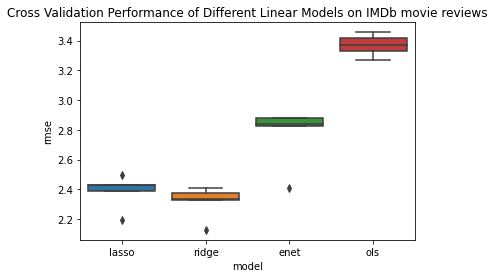

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
lasso = Lasso(alpha=7.75e-5)
ridge = Ridge(alpha=0.8875)
enet = ElasticNet(alpha=8e-4)
ols = LinearRegression()

models = [
    ("lasso", lasso),
    ("ridge", ridge),
    ("enet", enet),
    ("ols", ols)
]

results = []

for model_name, model in models:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")
    for s in scores:
        results.append({"model": model_name, "rmse": -s})



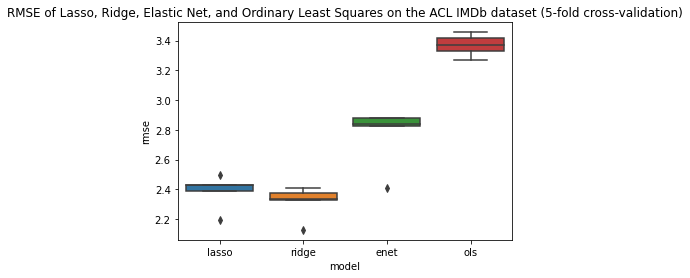

In [13]:
df = pd.DataFrame(results)
plt.title("RMSE of Lasso, Ridge, Elastic Net, and Ordinary Least Squares on the ACL IMDb dataset (5-fold cross-validation)")
plt.xlabel("Model")
plt.ylabel("Root Mean Squared Error (RMSE)")
sns.boxplot(data=df, x="model", y="rmse")
plt.savefig("../../results/imdb/acl_imdb_cross_validation_score_models.png",dpi=300)
plt.show()


In [ ]:
print(df.groupby('model').mean())
print(df.groupby('model').std())


           rmse
model          
enet   2.767987
lasso  2.388011
ols    3.367619
ridge  2.315311
           rmse
model          
enet   0.200707
lasso  0.115439
ols    0.071726
ridge  0.109337


In [ ]:
lasso = Lasso(alpha=7.75e-5)
lasso.fit(X_train,y_train)
print(f"Number of non-zero covariates used by Lasso: {np.sum(lasso.coef_ != 0)}")